## Intro
The goal of this notebook is to see how parking citations in Los Angeles disproportionately affect low-income groups and racial minority groups.

## Import packages

In [1]:
import dask.dataframe as dd
import geopandas as gpd
from shapely.geometry import Polygon
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import os
os.environ['HOME'] = '/home'

## LA citation data
This data was created and cleaned using Dask.

In [2]:
df = dd.read_parquet('~/data/processed/1614261610_2021-02-25_processed.parquet', engine='pyarrow',
                    columns=['violation_description', 'fine_amount', 'datetime', 'latitude', 'longitude'])
print("There are {} rows in this dataset.".format(df.shape[0].compute()))

There are 10745838 rows in this dataset.


## ZCTA .shp file
This .shp file is from https://www2.census.gov/geo/tiger/TIGER2019/ZCTA5/ and contains the geometries for all ZCTAs in the U.S. To reduce the size of the variable storing this data,the ZCTA was filtered from 90001 to 93591. I believe this includes all ZCTA for Los Angeles, plus a few more in SoCal.

In [3]:
# read data, filter for ZCTAs in LA
gpd_df = gpd.read_file(os.path.expanduser('~/data/external/tl_2019_us_zcta510/tl_2019_us_zcta510.shp'), 
                       bbox=Polygon([(-119.00, 34.85), (-119.00, 32.76), (-117.60, 32.76), (-117.60, 34.85)]))
gpd_df = gpd_df[['ZCTA5CE10', 'geometry']]
gpd_df = gpd_df.to_crs("EPSG:4326")
gpd_df.head()

/root/miniconda3/envs/luckyparkingenv/lib/python3.8/site-packages/geopandas/geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


,ZCTA5CE10,geometry
0,92705,"MULTIPOLYGON (((-117.83027 33.77326, -117.8300..."
1,92706,"POLYGON ((-117.90730 33.75995, -117.90725 33.7..."
2,92707,"MULTIPOLYGON (((-117.87836 33.66412, -117.8783..."
3,92708,"POLYGON ((-117.98054 33.71422, -117.98053 33.7..."
4,92780,"POLYGON ((-117.84389 33.73959, -117.84384 33.7..."


## Join LA data with ZCTA geometries
To get the ZCTA for each citation, a spatial join between the citation lat/long coordinates and the ZCTA geometries.

In [4]:
def get_ZCTA(row):
    """
    Given a row with longitude and latitude coordinates, return the ZCTA of the coordinates
    """
    _gpd_df = gpd.GeoDataFrame(geometry=gpd.points_from_xy(row['longitude'], row['latitude']))
    _gpd_df.crs = gpd_df.crs
    gpd_join = gpd.sjoin(_gpd_df, gpd_df, how='left', op="within")
    return gpd_join.ZCTA5CE10
df['ZCTA5CE10'] = df.map_partitions(get_ZCTA, meta=('ZCTA5CE10', 'object'))

## Census data
The income and race data of each ZCTA in California was obtained through the census API.

In [5]:
# download income data by zipcode
# Documentation: https://www.census.gov/data/developers/data-sets/acs-5year.html
# Examples:      https://api.census.gov/data/2019/acs/acs5/subject/examples.html
# Variables:     https://api.census.gov/data/2019/acs/acs5/subject/variables.html
# Table View:    https://data.census.gov/cedsci/table?q=acs%20income&g=8600000US90001&tid=ACSST5Y2019.S1901&hidePreview=true
census_income_response = requests.get('https://api.census.gov/data/2019/acs/acs5/subject?' + \
                        'get={}'.format(','.join(["S1901_C01_0" + str(x).zfill(2) + "E" for x in range(2,14)])) + \
                        '&for=zip%20code%20tabulation%20area:*' + \
                        '&in=state:06')
zcta_income = pd.DataFrame(census_income_response.json())
zcta_income.rename(columns=zcta_income.iloc[0], inplace = True)
zcta_income.drop([0], inplace = True)
zcta_income.drop('state', axis=1, inplace=True)
zcta_income.insert(0, "zcta", zcta_income.pop("zip code tabulation area"))
zcta_income[list(zcta_income)] = zcta_income[list(zcta_income)].astype('float')
zcta_income.zcta = zcta_income.zcta.astype('int').astype('string')
zcta_income.head()

,zcta,S1901_C01_002E,S1901_C01_003E,S1901_C01_004E,S1901_C01_005E,S1901_C01_006E,S1901_C01_007E,S1901_C01_008E,S1901_C01_009E,S1901_C01_010E,S1901_C01_011E,S1901_C01_012E,S1901_C01_013E
1,93252,9.1,8.4,17.2,12.7,20.0,15.5,9.8,1.1,3.5,2.6,36726.0,47845.0
2,93270,11.6,8.4,24.0,6.7,7.4,17.8,4.8,9.9,3.1,6.2,34023.0,65435.0
3,93291,5.6,5.5,11.0,6.9,12.6,15.3,14.4,13.9,7.0,7.9,61599.0,85165.0
4,93304,6.9,8.3,12.5,14.6,17.7,20.9,9.4,5.2,3.3,1.2,40710.0,53284.0
5,93306,5.6,4.4,11.2,9.9,14.6,17.8,12.2,14.1,5.3,4.9,55133.0,75527.0


In [6]:
# download race data by zipcode
# Documentation: https://www.census.gov/data/developers/data-sets/acs-5year.html
# Examples:      https://api.census.gov/data/2019/acs/acs5/profile/examples.html
# Variables:     https://api.census.gov/data/2019/acs/acs5/profile/variables.html
# Table View:    https://data.census.gov/cedsci/table?q=ACSDP1Y2019.DP05&g=8600000US90001&tid=ACSDP5Y2019.DP05&hidePreview=true
census_race_response = requests.get('https://api.census.gov/data/2019/acs/acs5/profile?' + \
                        'get={}'.format(','.join(["DP05_00" + str(x).zfill(2) + "E" + "," + "DP05_00" + str(x).zfill(2) + "PE" for x in range(63,86)])) + \
                        '&for=zip%20code%20tabulation%20area:*' + \
                        '&in=state:06')
zcta_race = pd.DataFrame(census_race_response.json())
zcta_race.rename(columns=zcta_race.iloc[0], inplace = True)
zcta_race.drop([0], inplace = True)
zcta_race.drop('state', axis=1, inplace=True)
zcta_race.insert(0, "zcta", zcta_race.pop("zip code tabulation area"))
zcta_race[list(zcta_race)] = zcta_race[list(zcta_race)].astype('float')
zcta_race.zcta = zcta_race.zcta.astype('int').astype('string')
zcta_race.head()

,zcta,DP05_0063E,DP05_0063PE,DP05_0064E,DP05_0064PE,DP05_0065E,DP05_0065PE,DP05_0066E,DP05_0066PE,DP05_0067E,...,DP05_0081E,DP05_0081PE,DP05_0082E,DP05_0082PE,DP05_0083E,DP05_0083PE,DP05_0084E,DP05_0084PE,DP05_0085E,DP05_0085PE
1,93252,2488.0,2488.0,2186.0,87.9,24.0,1.0,117.0,4.7,152.0,...,0.0,0.0,0.0,0.0,81.0,3.3,17.0,0.7,64.0,2.6
2,93270,5367.0,5367.0,3486.0,65.0,10.0,0.2,249.0,4.6,70.0,...,4.0,0.1,0.0,0.0,16.0,0.3,0.0,0.0,16.0,0.3
3,93291,59270.0,59270.0,42247.0,71.3,838.0,1.4,1387.0,2.3,6352.0,...,157.0,0.3,168.0,0.3,1081.0,1.8,80.0,0.1,1001.0,1.7
4,93304,49115.0,49115.0,28519.0,58.1,6996.0,14.2,1197.0,2.4,1441.0,...,64.0,0.1,41.0,0.1,511.0,1.0,38.0,0.1,473.0,1.0
5,93306,72280.0,72280.0,60532.0,83.7,2654.0,3.7,1554.0,2.1,2241.0,...,159.0,0.2,176.0,0.2,914.0,1.3,84.0,0.1,830.0,1.1


In [7]:
#merge income and race to form demographic dataframe
zcta_dem = zcta_income.merge(zcta_race, on='zcta', how='outer')
zcta_dem.head()

,zcta,S1901_C01_002E,S1901_C01_003E,S1901_C01_004E,S1901_C01_005E,S1901_C01_006E,S1901_C01_007E,S1901_C01_008E,S1901_C01_009E,S1901_C01_010E,...,DP05_0081E,DP05_0081PE,DP05_0082E,DP05_0082PE,DP05_0083E,DP05_0083PE,DP05_0084E,DP05_0084PE,DP05_0085E,DP05_0085PE
0,93252,9.1,8.4,17.2,12.7,20.0,15.5,9.8,1.1,3.5,...,0.0,0.0,0.0,0.0,81.0,3.3,17.0,0.7,64.0,2.6
1,93270,11.6,8.4,24.0,6.7,7.4,17.8,4.8,9.9,3.1,...,4.0,0.1,0.0,0.0,16.0,0.3,0.0,0.0,16.0,0.3
2,93291,5.6,5.5,11.0,6.9,12.6,15.3,14.4,13.9,7.0,...,157.0,0.3,168.0,0.3,1081.0,1.8,80.0,0.1,1001.0,1.7
3,93304,6.9,8.3,12.5,14.6,17.7,20.9,9.4,5.2,3.3,...,64.0,0.1,41.0,0.1,511.0,1.0,38.0,0.1,473.0,1.0
4,93306,5.6,4.4,11.2,9.9,14.6,17.8,12.2,14.1,5.3,...,159.0,0.2,176.0,0.2,914.0,1.3,84.0,0.1,830.0,1.1


In [8]:
# find agg data per ZCTA
gpd_join_dem = pd.DataFrame(df.groupby('ZCTA5CE10').size().compute(), columns=['count']).reset_index()

# join with ZCTA demographics
gpd_join_dem = gpd_join_dem.merge(zcta_dem, how='left', left_on='ZCTA5CE10', right_on='zcta')

# join with geometry
gpd_join_dem = gpd.GeoDataFrame(gpd_join_dem.merge(gpd_df[['ZCTA5CE10', 'geometry']], how='left', on='ZCTA5CE10'))

# rename some columns
gpd_join_dem.rename({"S1901_C01_012E": "median_income"}, axis=1, inplace=True)
gpd_join_dem.rename({"DP05_0070E": "population"}, axis=1, inplace=True)
gpd_join_dem.rename({"DP05_0071PE": "hispanic_percent"}, axis=1, inplace=True)

# create more attributes
gpd_join_dem['area'] = gpd_join_dem.geometry.apply(lambda x: x.area)
gpd_join_dem['count_normalized_area'] = gpd_join_dem['count']/gpd_join_dem['area']
gpd_join_dem['population_normalized_area'] = gpd_join_dem['population']/gpd_join_dem['area']
gpd_join_dem['count_per_thousand'] = gpd_join_dem['count'] / (gpd_join_dem['population'] / 1000)
gpd_join_dem['nonwhite_percent'] = 100-gpd_join_dem['DP05_0064PE']
gpd_join_dem['diversity_index'] = 1-(gpd_join_dem['DP05_0064PE']/100)**2-(gpd_join_dem['DP05_0065PE']/100)**2-(gpd_join_dem['DP05_0066PE']/100)**2-(gpd_join_dem['DP05_0067PE']/100)**2-(gpd_join_dem['DP05_0068PE']/100)**2-(gpd_join_dem['DP05_0069PE']/100)**2
labels4=['0-25%', '25-50%', '50-75%', '75-100%']
labels5=['0-20%', '20-40%', '40-60%', '60-80%', '80-100%']
gpd_join_dem['median_income_quantile'] = pd.qcut(gpd_join_dem['median_income'], q=5, labels=labels5)
gpd_join_dem['nonwhite_percent_quantile'] = pd.qcut(gpd_join_dem['nonwhite_percent'], q=5, labels=labels5)
gpd_join_dem['hispanic_percent_quantile'] = pd.qcut(gpd_join_dem['hispanic_percent'], q=5, labels=labels5)
gpd_join_dem['diversity_index_quantile'] = pd.qcut(gpd_join_dem['diversity_index'], q=5, labels=labels5)
gpd_join_dem['coords'] = gpd_join_dem['geometry'].apply(lambda x: x.representative_point().coords[:])
gpd_join_dem['coords'] = [coords[0] for coords in gpd_join_dem['coords']]

# turn to gpd
gpd_join_dem.head(3)

,ZCTA5CE10,count,zcta,S1901_C01_002E,S1901_C01_003E,S1901_C01_004E,S1901_C01_005E,S1901_C01_006E,S1901_C01_007E,S1901_C01_008E,...,count_normalized_area,population_normalized_area,count_per_thousand,nonwhite_percent,diversity_index,median_income_quantile,nonwhite_percent_quantile,hispanic_percent_quantile,diversity_index_quantile,coords
0,90001,12516,90001,8.2,5.6,12.9,12.5,16.4,19.6,11.1,...,1.414360e+07,6.761263e+07,209.185720,57.2,0.582049,0-20%,60-80%,80-100%,60-80%,"(-118.24987397455607, 33.97394359273794)"
1,90002,32898,90002,10.4,10.5,14.4,11.6,15.5,16.4,9.4,...,4.253459e+07,6.891540e+07,617.200105,55.9,0.646318,0-20%,60-80%,80-100%,80-100%,"(-118.24700629856042, 33.9494429250179)"
2,90003,94413,90003,9.4,8.2,14.7,11.3,16.8,16.6,11.3,...,1.052291e+08,8.217660e+07,1280.523532,66.2,0.642201,0-20%,80-100%,80-100%,80-100%,"(-118.27391427295302, 33.96348135555456)"


## Let's plot citation count per ZCTA

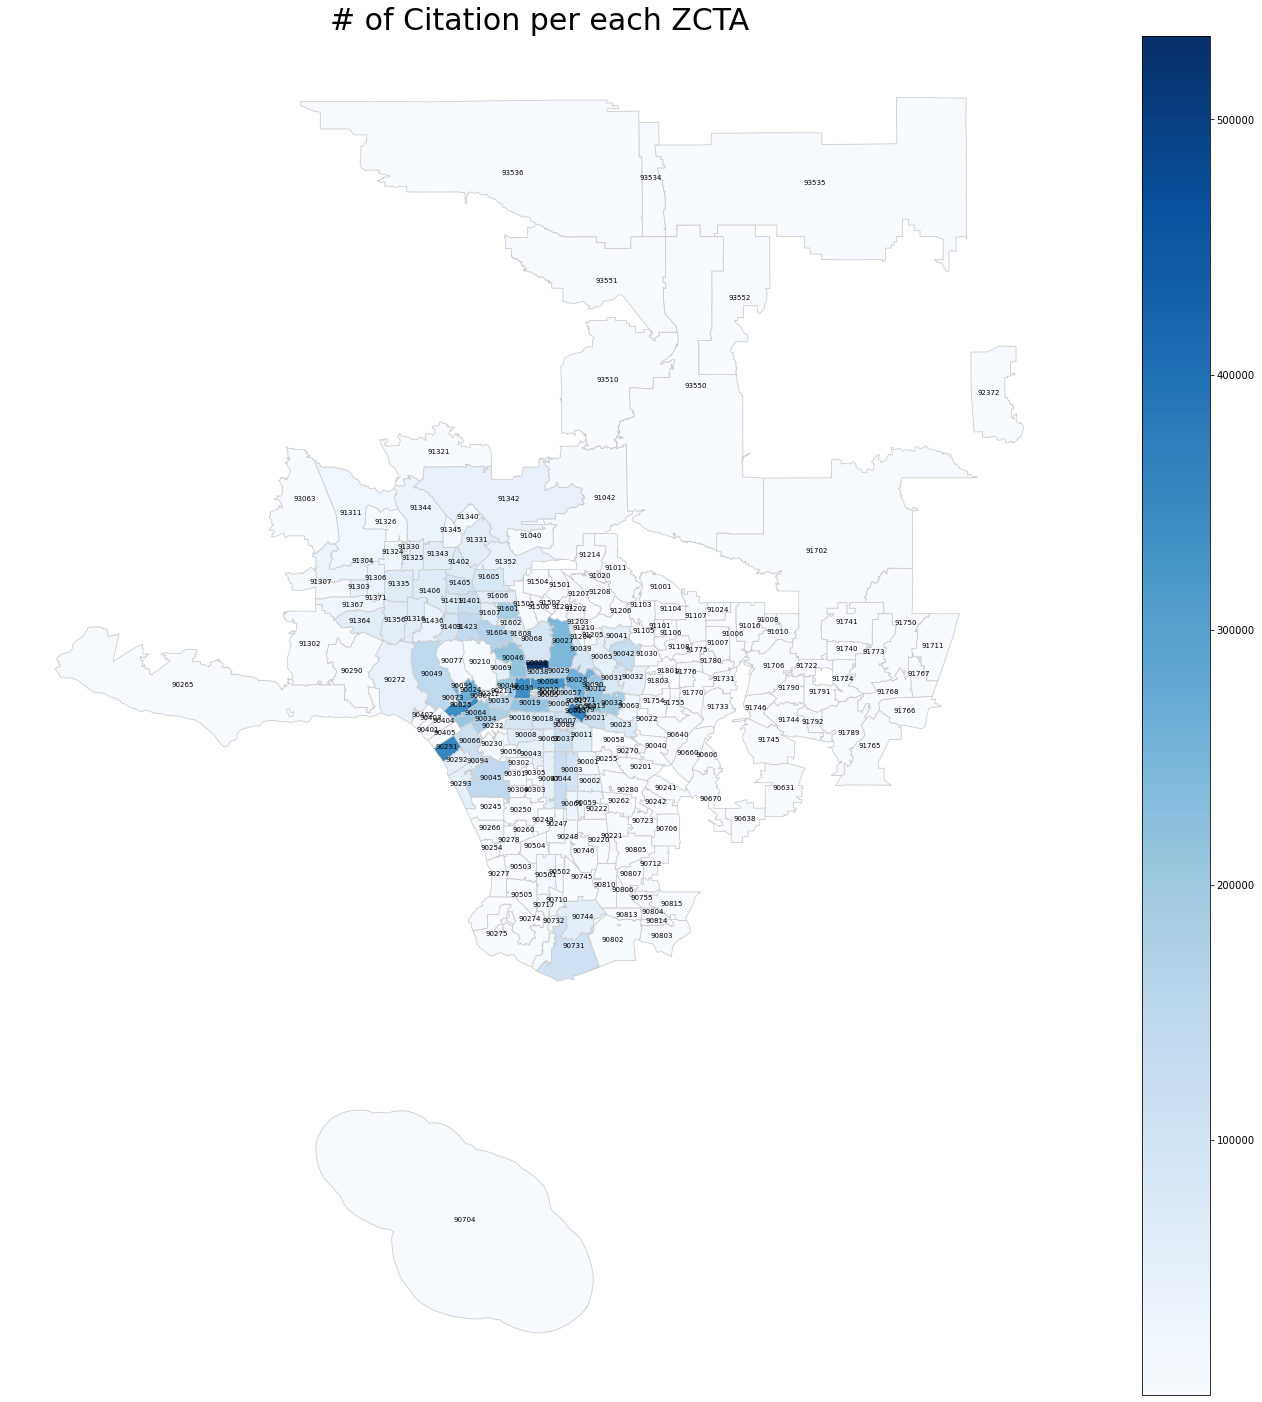

In [9]:
def plot_ZCTA(df, variable, title, zcta_text = False):
    
    # plot
    fig, ax = plt.subplots(1, figsize=(25, 25))
    ax.axis('off')
    ax.set_title(title, fontdict={'fontsize': '30', 'fontweight' : '3'})
    fig.colorbar(plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=min(df[variable]), vmax=max(df[variable]))))

    # create map
    df[df[variable]>0].plot(column=variable, cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8')
    
    # annotate ZCTA
    if zcta_text:
        for idx, row in df.iterrows():
            plt.annotate(text=row['ZCTA5CE10'], xy=row['coords'],horizontalalignment='center', fontsize=7)
    
plot_ZCTA(gpd_join_dem, 'count', '# of Citation per each ZCTA', True)

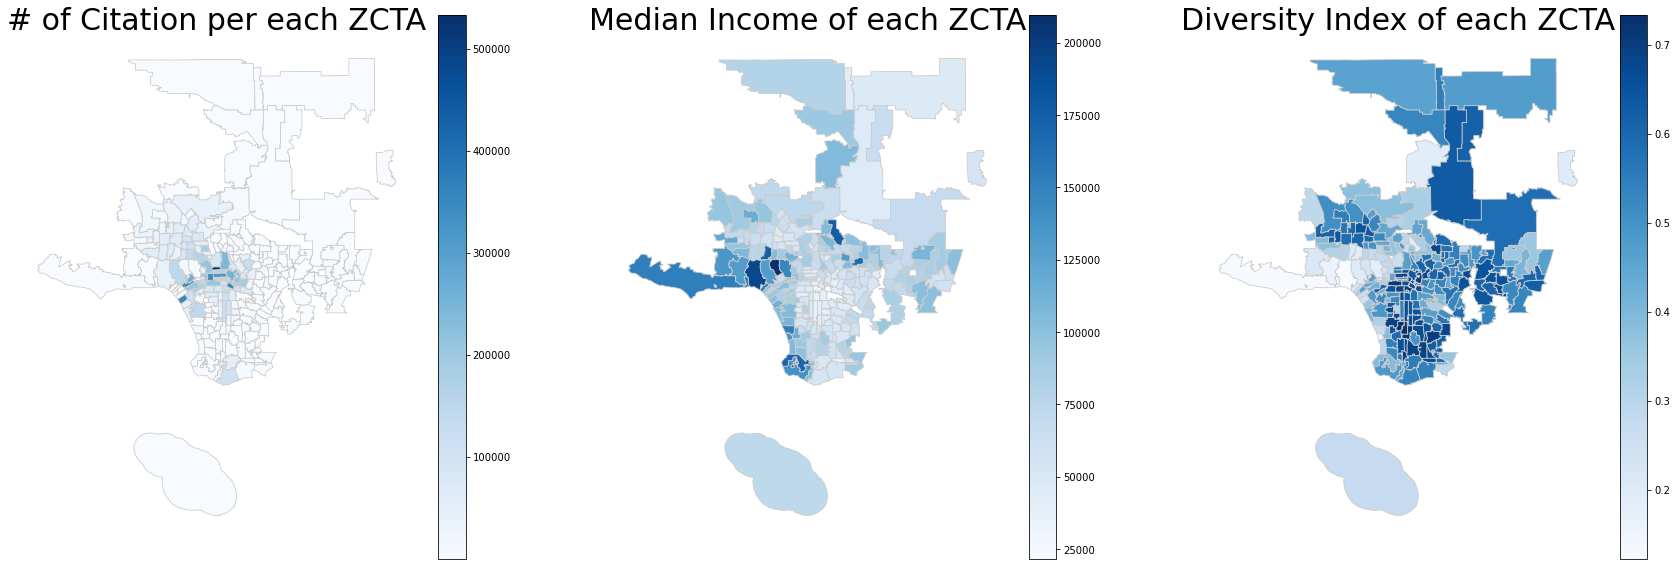

In [10]:
def plot_ZCTA_multi(df, zcta_text = False):
    
    # figure settings
    fig, ax = plt.subplots(1, 3, figsize=(30, 10), sharex=True, sharey=True)
    
    # plot count
    ax[0].axis('off')
    ax[0].set_title('# of Citation per each ZCTA', fontdict={'fontsize': '30', 'fontweight' : '3'})
    df.plot(column='count', cmap='Blues', linewidth=0.8, ax=ax[0], edgecolor='0.8', legend=True)
    
    # plot median_income
    ax[1].axis('off')
    ax[1].set_title('Median Income of each ZCTA', fontdict={'fontsize': '30', 'fontweight' : '3'})
    df[df['median_income']>0].plot(column='median_income', cmap='Blues', linewidth=0.8, ax=ax[1], edgecolor='0.8', legend=True)
    
    # plot diversity_index
    ax[2].axis('off')
    ax[2].set_title('Diversity Index of each ZCTA', fontdict={'fontsize': '30', 'fontweight' : '3'})
    df[df['diversity_index']>0].plot(column='diversity_index', cmap='Blues', linewidth=0.8, ax=ax[2], edgecolor='0.8', legend=True)
    
    # annotate ZCTA
    #if zcta_text:
    #    for idx, row in df.iterrows():
    #        plt.annotate(text=row['ZCTA5CE10'], xy=row['coords'],horizontalalignment='center')
    
plot_ZCTA_multi(gpd_join_dem)

## Are there more parking citations in low-income areas?

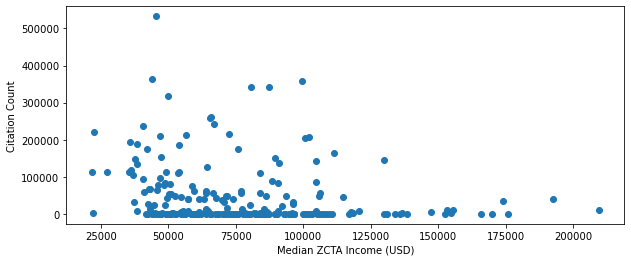

In [11]:
# filter out null median income data and low population
gpd_join_dem_income = gpd_join_dem[gpd_join_dem['median_income'] > 0].reset_index()
gpd_join_dem_income = gpd_join_dem_income[gpd_join_dem_income['population'] > 500]

# plot
def scatter_graph(df, x, x_title, y, y_title):
    
    fig, ax = plt.subplots(figsize=(10,4))
    ax.scatter(gpd_join_dem_income[x], gpd_join_dem_income[y])
    ax.set_xlabel(x_title)
    ax.set_ylabel(y_title)
    plt.show()
    
scatter_graph(gpd_join_dem_income, 'median_income', 'Median ZCTA Income (USD)', 'count', 'Citation Count')

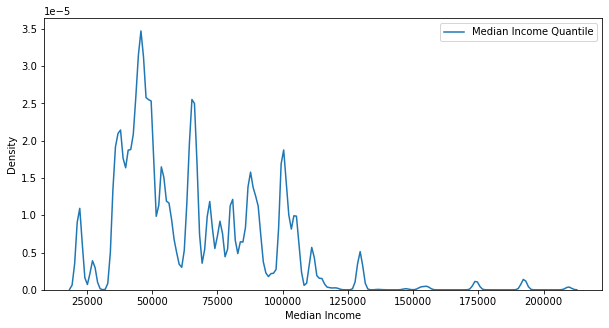

In [12]:
def kdeplots(_df, y, y_title):
    fig, ax = plt.subplots(figsize=(10,5))
    
    # plot density
    # reverse engineer: each citation is a dot in the kde plot
    _list = []
    for idx, row in _df.iterrows():
        if (row[y]) > 0:
            _list += [float(row[y])] * row['count']
    sns.kdeplot(ax=ax, x=_list)
    ax.set_xlabel(y_title)
    ax.legend([y_title+" Quantile"])
    
kdeplots(gpd_join_dem_income, 'median_income', "Median Income")

In [13]:
def get_quantile_data(df, variable):
    quantile_variable = variable+'_quantile'
    _df = df.groupby(quantile_variable).agg({'count':['sum'], 'population':['sum']}).reset_index()
    _df.columns = [quantile_variable, 'count', 'population']
    _df['count_per_thousand'] = _df['count'] / (_df['population']/1000)
    return _df

income_quantile_bar_data = get_quantile_data(gpd_join_dem_income, 'median_income')
income_quantile_bar_data.head()

,median_income_quantile,count,population,count_per_thousand
0,0-20%,3941882,2038292.0,1933.914277
1,20-40%,1674801,2297286.0,729.034609
2,40-60%,1921243,2053778.0,935.467709
3,60-80%,1557781,1661629.0,937.502294
4,80-100%,1605663,1257726.0,1276.639745


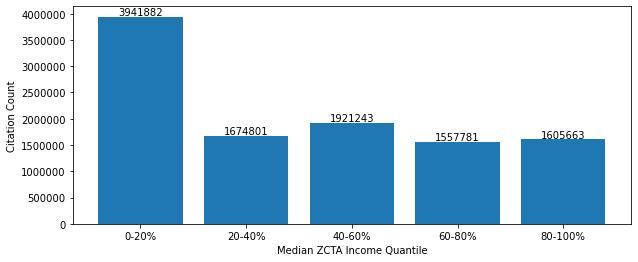

In [14]:
# plot
def quantile_bar_graph(df, x, x_title, y, y_title):
    
    fig, ax = plt.subplots(figsize=(10,4))
    ax.bar(df[x], df[y])
    ax.set_xlabel(x_title)
    ax.set_ylabel(y_title)
    ax.ticklabel_format(style='plain', axis='y')
    for i, v in enumerate(df[y]):
        ax.text(i, v+max(df[y])*.007, str(round(v)), color='black', horizontalalignment='center')
    plt.show();
    
quantile_bar_graph(income_quantile_bar_data, 'median_income_quantile', 'Median ZCTA Income Quantile', 'count', 'Citation Count')

## Are there more parking citations in low-income areas, if we account for ZCTA population?

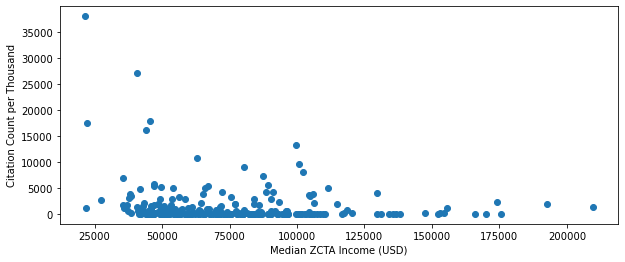

In [15]:
scatter_graph(gpd_join_dem_income, 'median_income', 'Median ZCTA Income (USD)', 'count_per_thousand', 'Citation Count per Thousand')

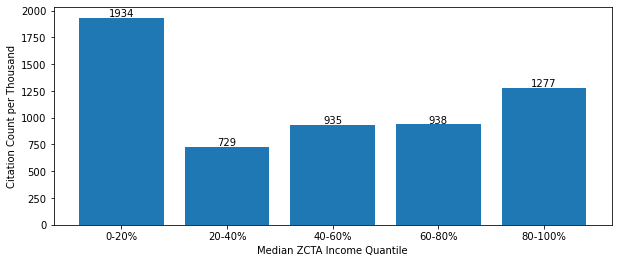

In [16]:
quantile_bar_graph(income_quantile_bar_data, 'median_income_quantile', 'Median ZCTA Income Quantile', 'count_per_thousand', 'Citation Count per Thousand')

## Are there more parking citations in areas with greater non-white populations?

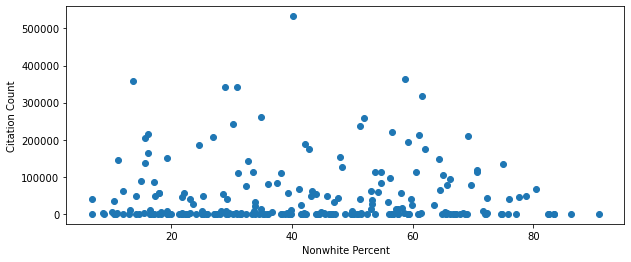

In [17]:
# filter out race
gpd_join_dem_race = gpd_join_dem[gpd_join_dem['population'] > 500].reset_index()

scatter_graph(gpd_join_dem_race, 'nonwhite_percent', 'Nonwhite Percent', 'count', 'Citation Count')

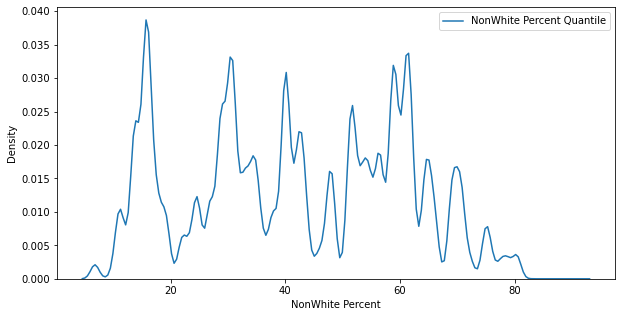

In [18]:
kdeplots(gpd_join_dem_race, 'nonwhite_percent', "NonWhite Percent")

In [19]:
nonwhite_quantile_bar_data = get_quantile_data(gpd_join_dem_race, 'nonwhite_percent')
nonwhite_quantile_bar_data

,nonwhite_percent_quantile,count,population,count_per_thousand
0,0-20%,2053830,1283604.0,1600.049548
1,20-40%,2348199,1643377.0,1428.886372
2,40-60%,1808186,2131113.0,848.470259
3,60-80%,2573863,2294102.0,1121.947934
4,80-100%,1932751,1964511.0,983.833127


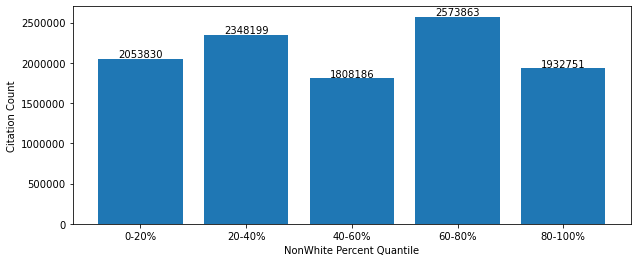

In [20]:
quantile_bar_graph(nonwhite_quantile_bar_data, 'nonwhite_percent_quantile', 'NonWhite Percent Quantile', 'count', 'Citation Count')

## Are there more parking citations in areas with greater non-white populations, if we account for ZCTA population (proxy for size)?

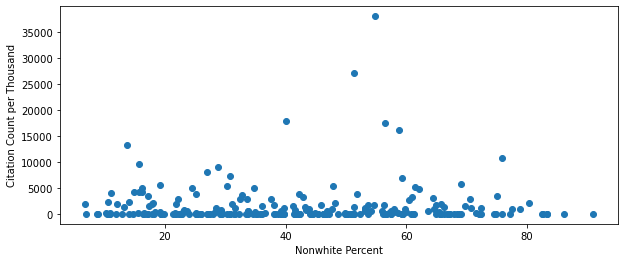

In [21]:
scatter_graph(gpd_join_dem_race, 'nonwhite_percent', 'Nonwhite Percent', 'count_per_thousand', 'Citation Count per Thousand')

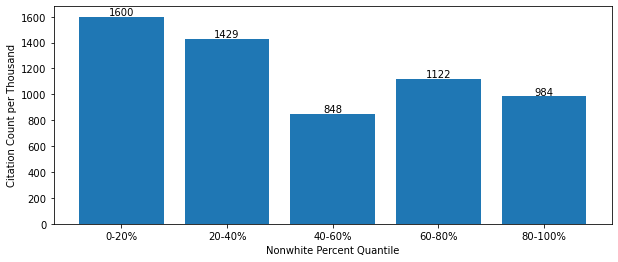

In [22]:
quantile_bar_graph(nonwhite_quantile_bar_data, 'nonwhite_percent_quantile', 'Nonwhite Percent Quantile', 'count_per_thousand', 'Citation Count per Thousand')

## Are there more parking citations in areas with greater Hispanic populations?

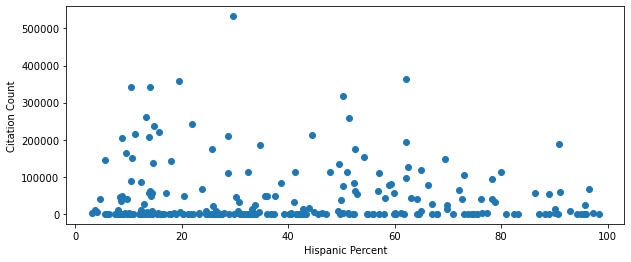

In [23]:
scatter_graph(gpd_join_dem_race, 'hispanic_percent', 'Hispanic Percent', 'count', 'Citation Count')

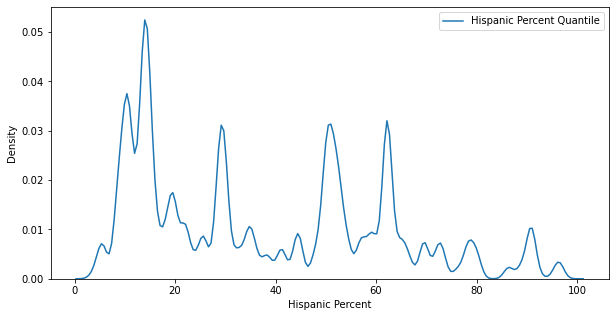

In [24]:
kdeplots(gpd_join_dem_race, 'hispanic_percent', "Hispanic Percent")

In [25]:
hispanic_quantile_bar_data = get_quantile_data(gpd_join_dem_race, 'hispanic_percent')
hispanic_quantile_bar_data

,hispanic_percent_quantile,count,population,count_per_thousand
0,0-20%,1949857,1095172.0,1780.411661
1,20-40%,2528921,1383286.0,1828.198218
2,40-60%,1685693,1751913.0,962.201319
3,60-80%,3248070,2414520.0,1345.223895
4,80-100%,1304288,2671816.0,488.165353


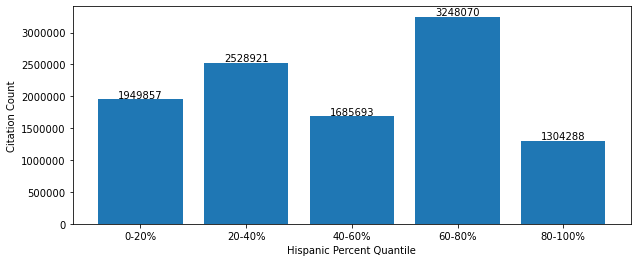

In [26]:
quantile_bar_graph(hispanic_quantile_bar_data, 'hispanic_percent_quantile', 'Hispanic Percent Quantile', 'count', 'Citation Count')

## Are there more parking citations in areas with greater Hispanic populations, if we account for ZCTA population (proxy for size)?

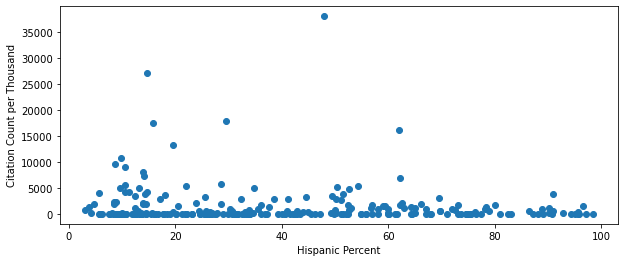

In [27]:
scatter_graph(gpd_join_dem_race, 'hispanic_percent', 'Hispanic Percent', 'count_per_thousand', 'Citation Count per Thousand')

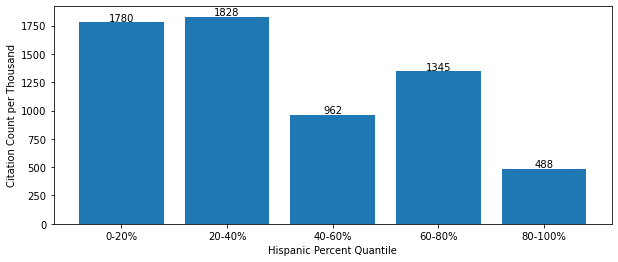

In [28]:
quantile_bar_graph(hispanic_quantile_bar_data, 'hispanic_percent_quantile', 'Hispanic Percent Quantile', 'count_per_thousand', 'Citation Count per Thousand')

## Are there more parking citations in areas with greater diversity?

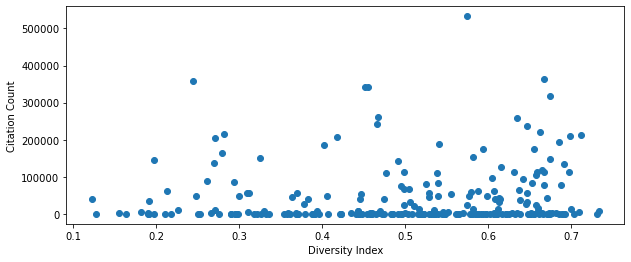

In [29]:
scatter_graph(gpd_join_dem_race, 'diversity_index', 'Diversity Index', 'count', 'Citation Count')

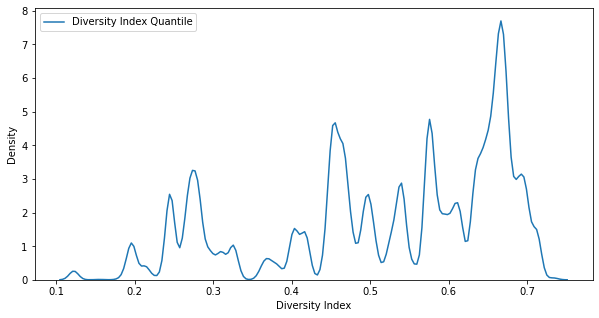

In [30]:
kdeplots(gpd_join_dem_race, 'diversity_index', "Diversity Index")

In [31]:
diversity_quantile_bar_data = get_quantile_data(gpd_join_dem_race, 'diversity_index')
diversity_quantile_bar_data

,diversity_index_quantile,count,population,count_per_thousand
0,0-20%,1948500,1141275.0,1707.301045
1,20-40%,2096161,1639646.0,1278.422903
2,40-60%,1250865,2138488.0,584.929633
3,60-80%,2066435,2188142.0,944.378838
4,80-100%,3354868,2209156.0,1518.619781


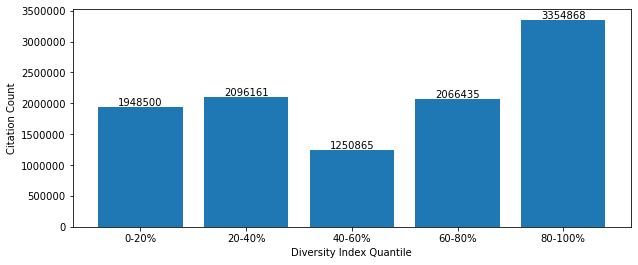

In [32]:
quantile_bar_graph(diversity_quantile_bar_data, 'diversity_index_quantile', 'Diversity Index Quantile', 'count', 'Citation Count')

## Are there more parking citations in areas with greater diversity, if we account for ZCTA population (proxy for size)?

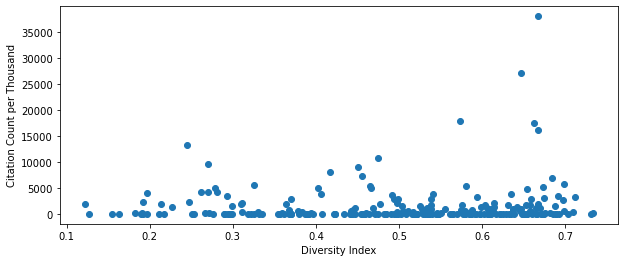

In [33]:
scatter_graph(gpd_join_dem_race, 'diversity_index', 'Diversity Index', 'count_per_thousand', 'Citation Count per Thousand')

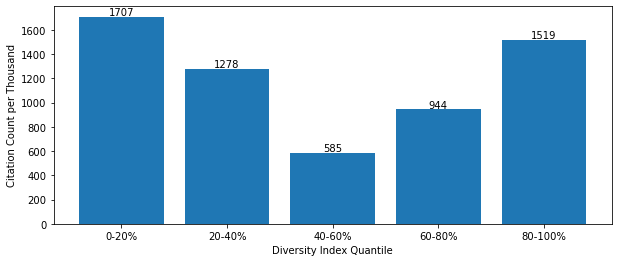

In [34]:
quantile_bar_graph(diversity_quantile_bar_data, 'diversity_index_quantile', 'Diversity Index Quantile', 'count_per_thousand', 'Citation Count per Thousand')

## Do areas with lower income populations get more street cleaning tickets?

In [64]:
# filter df for street cleaning violations
streetclean_df = df[(df['violation_description'].str.contains("CLEAN")) & (df.ZCTA5CE10.notnull())]

# find agg data per ZCTA
streetclean_join_dem = pd.DataFrame(streetclean_df.groupby('ZCTA5CE10').size().compute(), columns=['count']).reset_index()

# join with ZCTA demographics
streetclean_join_dem = streetclean_join_dem.merge(zcta_dem, how='left', left_on='ZCTA5CE10', right_on='zcta')

# join with geometry
streetclean_join_dem = gpd.GeoDataFrame(streetclean_join_dem.merge(gpd_df[['ZCTA5CE10', 'geometry']], how='left', on='ZCTA5CE10'))

# rename some columns
streetclean_join_dem.rename({"S1901_C01_012E": "median_income"}, axis=1, inplace=True)
streetclean_join_dem.rename({"DP05_0070E": "population"}, axis=1, inplace=True)
streetclean_join_dem.rename({"DP05_0071PE": "hispanic_percent"}, axis=1, inplace=True)

# create more attributes
streetclean_join_dem['area'] = streetclean_join_dem.geometry.apply(lambda x: x.area)
streetclean_join_dem['count_normalized_area'] = streetclean_join_dem['count']/streetclean_join_dem['area']
streetclean_join_dem['population_normalized_area'] = streetclean_join_dem['population']/streetclean_join_dem['area']
streetclean_join_dem['count_per_thousand'] = streetclean_join_dem['count'] / (streetclean_join_dem['population'] / 1000)
streetclean_join_dem['nonwhite_percent'] = 100-streetclean_join_dem['DP05_0064PE']
streetclean_join_dem['diversity_index'] = 1-(streetclean_join_dem['DP05_0064PE']/100)**2-(streetclean_join_dem['DP05_0065PE']/100)**2-(streetclean_join_dem['DP05_0066PE']/100)**2-(streetclean_join_dem['DP05_0067PE']/100)**2-(streetclean_join_dem['DP05_0068PE']/100)**2-(streetclean_join_dem['DP05_0069PE']/100)**2
labels4=['0-25%', '25-50%', '50-75%', '75-100%']
labels5=['0-20%', '20-40%', '40-60%', '60-80%', '80-100%']
streetclean_join_dem['median_income_quantile'] = pd.qcut(streetclean_join_dem['median_income'], q=5, labels=labels5)
streetclean_join_dem['nonwhite_percent_quantile'] = pd.qcut(streetclean_join_dem['nonwhite_percent'], q=5, labels=labels5)
streetclean_join_dem['hispanic_percent_quantile'] = pd.qcut(streetclean_join_dem['hispanic_percent'], q=5, labels=labels5)
streetclean_join_dem['diversity_index_quantile'] = pd.qcut(streetclean_join_dem['diversity_index'], q=5, labels=labels5)
streetclean_join_dem['coords'] = streetclean_join_dem['geometry'].apply(lambda x: x.representative_point().coords[:])
streetclean_join_dem['coords'] = [coords[0] for coords in streetclean_join_dem['coords']]

# turn to gpd
streetclean_join_dem.head(3)

,ZCTA5CE10,count,zcta,S1901_C01_002E,S1901_C01_003E,S1901_C01_004E,S1901_C01_005E,S1901_C01_006E,S1901_C01_007E,S1901_C01_008E,...,count_normalized_area,population_normalized_area,count_per_thousand,nonwhite_percent,diversity_index,median_income_quantile,nonwhite_percent_quantile,hispanic_percent_quantile,diversity_index_quantile,coords
0,90001,3742,90001,8.2,5.6,12.9,12.5,16.4,19.6,11.1,...,4.228614e+06,6.761263e+07,62.541784,57.2,0.582049,0-20%,60-80%,80-100%,60-80%,"(-118.24987397455607, 33.97394359273794)"
1,90002,16372,90002,10.4,10.5,14.4,11.6,15.5,16.4,9.4,...,2.116774e+07,6.891540e+07,307.155454,55.9,0.646318,0-20%,60-80%,80-100%,80-100%,"(-118.24700629856042, 33.9494429250179)"
2,90003,29307,90003,9.4,8.2,14.7,11.3,16.8,16.6,11.3,...,3.266445e+07,8.217660e+07,397.490845,66.2,0.642201,0-20%,80-100%,80-100%,80-100%,"(-118.27391427295302, 33.96348135555456)"


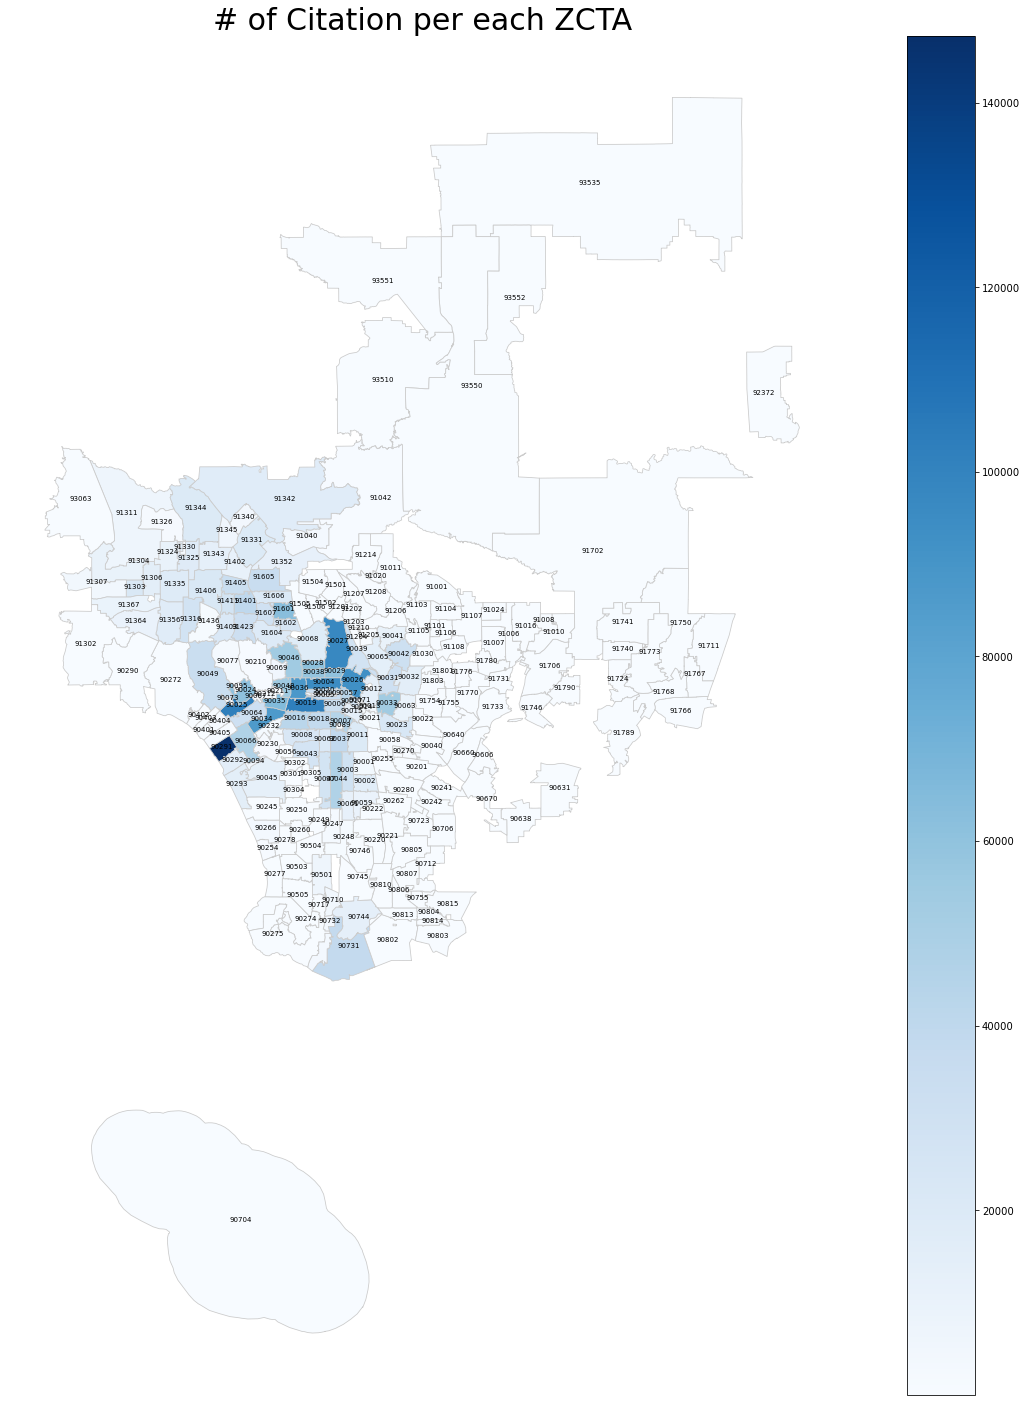

In [66]:
plot_ZCTA(streetclean_join_dem, 'count', '# of Citation per each ZCTA', True)

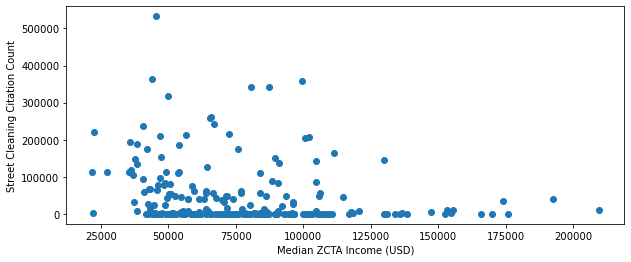

In [67]:
scatter_graph(streetclean_join_dem, 'median_income', 'Median ZCTA Income (USD)', 'count', 'Street Cleaning Citation Count')

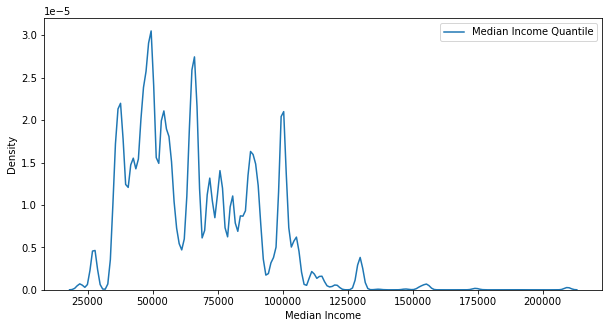

In [68]:
kdeplots(streetclean_join_dem, 'median_income', "Median Income")

In [69]:
streetclean_income_quantile_bar_data = get_quantile_data(streetclean_join_dem, 'median_income')
streetclean_income_quantile_bar_data

,median_income_quantile,count,population,count_per_thousand
0,0-20%,876760,2046110.0,428.500911
1,20-40%,591927,2183243.0,271.122821
2,40-60%,651363,1888192.0,344.966508
3,60-80%,479421,1548976.0,309.508346
4,80-100%,385599,1136721.0,339.220442


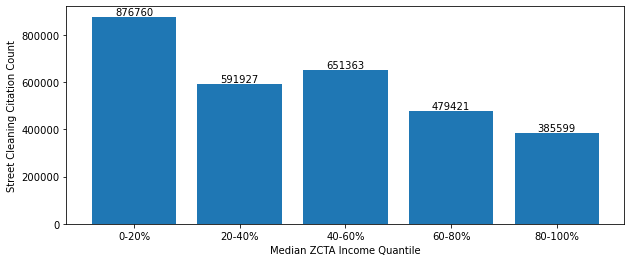

In [71]:
quantile_bar_graph(streetclean_income_quantile_bar_data, 'median_income_quantile', 'Median ZCTA Income Quantile', 'count', 'Street Cleaning Citation Count')